In [101]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
import numpy as np
from scipy.optimize import least_squares
from aa_helpers import create_plot_with_background
import pandas as pd
import glob
import seaborn as sns


In [102]:
df = pd.read_feather("combined_all_lambda_data.feather")
df

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_py,gamtwo_pz,gamtwo_vx,gamtwo_vy,gamtwo_vz,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,3122,1,134217728,-0.139277,0.062614,31.113912,-0.067507,0.000640,...,0.082274,3.843211,-4.236915,1.875058,940.263365,-182.985431,130.331637,6940.804748,3.073184,0.0
2,2,4,3122,1,134217728,-1.666138,0.211775,30.953969,-0.027048,0.006753,...,-0.035283,2.576297,-16.709645,2.127195,331.802817,-236.338462,-40.261238,3426.886648,0.948990,0.0
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,3122,1,134217728,-0.728119,-0.635623,31.608930,-0.042067,0.001390,...,-0.015382,1.622836,-39.878694,-34.774637,1675.921870,-96.233964,-84.811255,6954.767017,5.966232,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563785,499996,4,3122,1,134217728,-0.884341,-0.615085,37.018614,-0.011745,-0.024622,...,0.054056,4.083450,-3.373053,-2.362499,184.886373,-227.016039,87.304909,6958.468336,0.329498,0.0
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563787,499998,4,3122,1,134217728,-0.165018,-0.626539,24.329761,-0.050402,0.038077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
p_pi_minus_decays = df[
    df['prot_id'].notna() & 
    df['pimin_id'].notna() &
    df['neut_id'].isna() &    
    df['pizero_id'].isna()    
].copy()


In [104]:
m_proton = 0.93827  
m_pion = 0.13957    


p_pi_minus_decays['prot_E'] = np.sqrt(
    p_pi_minus_decays['prot_px']**2 + 
    p_pi_minus_decays['prot_py']**2 + 
    p_pi_minus_decays['prot_pz']**2 + 
    m_proton**2
)

p_pi_minus_decays['pimin_E'] = np.sqrt(
    p_pi_minus_decays['pimin_px']**2 + 
    p_pi_minus_decays['pimin_py']**2 + 
    p_pi_minus_decays['pimin_pz']**2 + 
    m_pion**2
)


p_pi_minus_decays['lambda_E'] = p_pi_minus_decays['prot_E'] + p_pi_minus_decays['pimin_E']


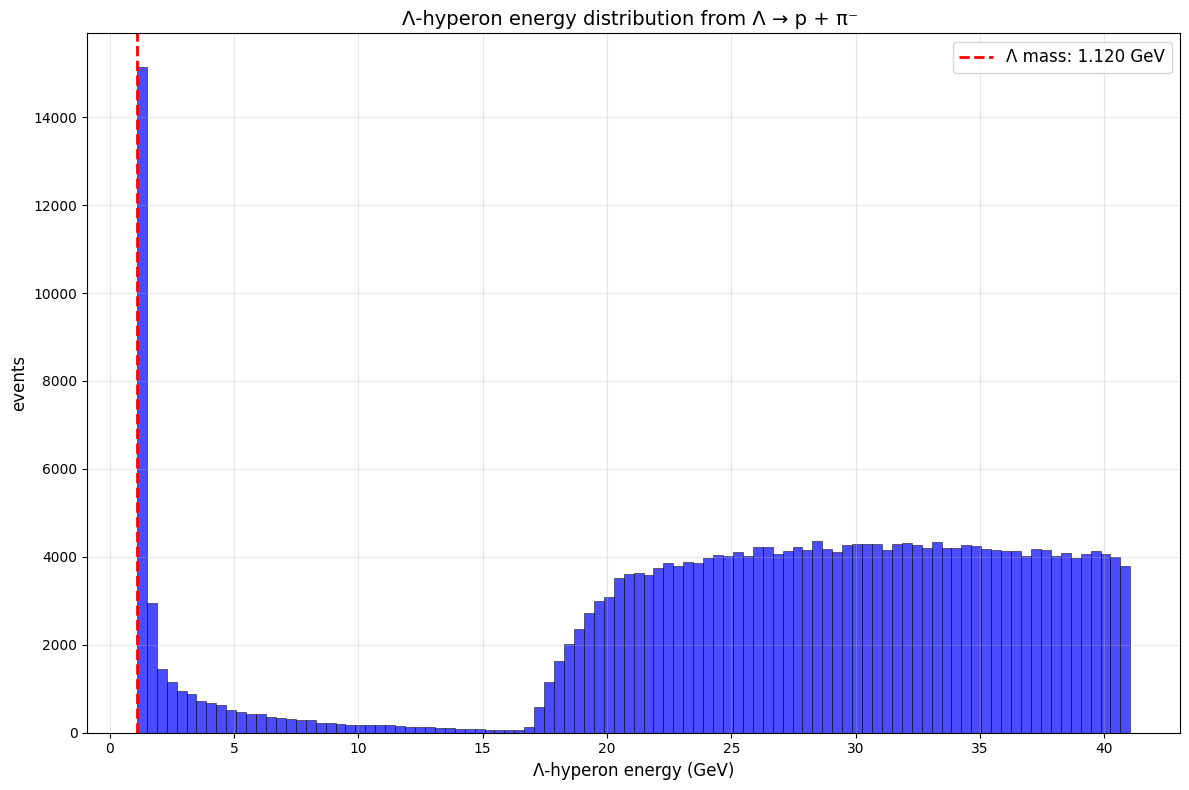

In [105]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['lambda_E'], bins=100, alpha=0.7, color='blue', 
         edgecolor='black', linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ mass: 1.120 GeV')

plt.xlabel('Λ-hyperon energy (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Λ-hyperon energy distribution from Λ → p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [106]:
# Calculate invariant mass of p + π⁻ system
def calculate_invariant_mass(row):
    E_total = row['prot_E'] + row['pimin_E']
    px_total = row['prot_px'] + row['pimin_px']
    py_total = row['prot_py'] + row['pimin_py']
    pz_total = row['prot_pz'] + row['pimin_pz']
    p_total_sq = px_total**2 + py_total**2 + pz_total**2
    return np.sqrt(E_total**2 - p_total_sq)

p_pi_minus_decays['invariant_mass'] = p_pi_minus_decays.apply(calculate_invariant_mass, axis=1)


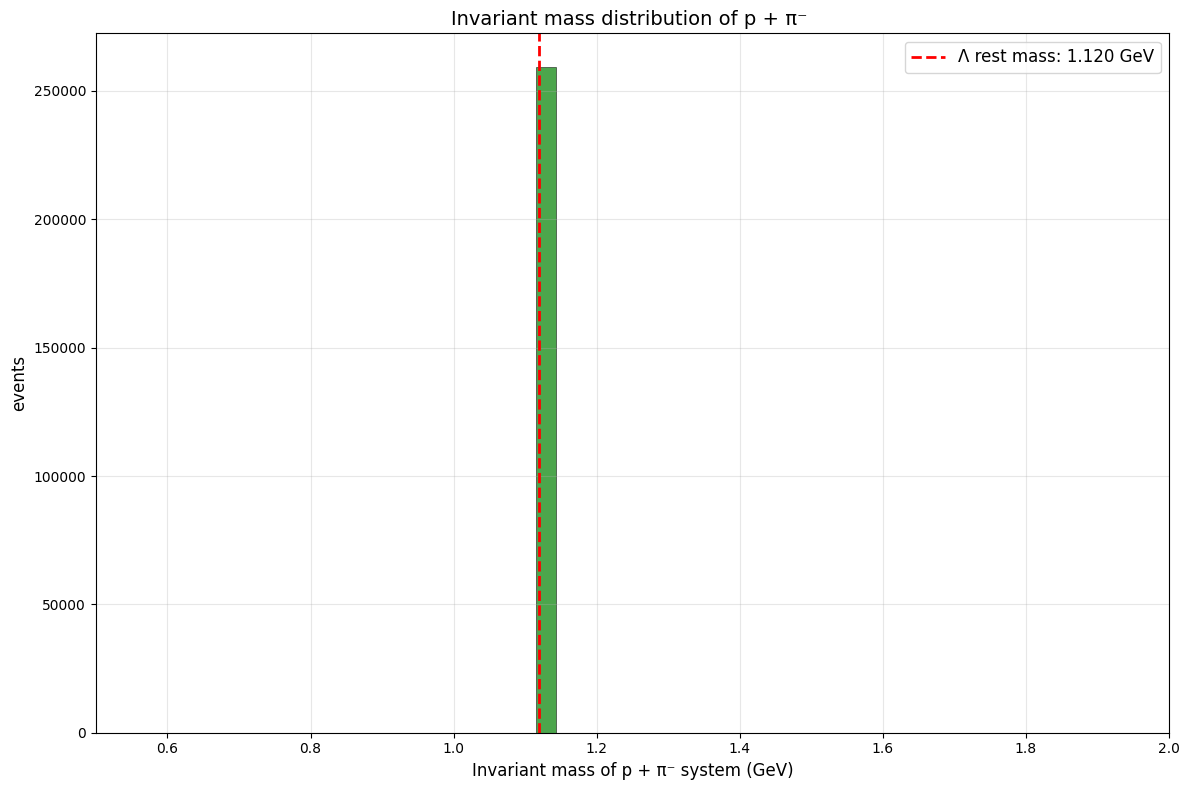

In [107]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['invariant_mass'], 
         bins=100, 
         alpha=0.7, 
         color='green', 
         edgecolor='black', 
         linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ rest mass: 1.120 GeV')

plt.xlabel('Invariant mass of p + π⁻ system (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Invariant mass distribution of p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)

plt.grid(True, alpha=0.3)
plt.xlim(0.5, 2.0)
plt.tight_layout()
plt.show()

In [108]:
df_p_pi_minis = p_pi_minus_decays.copy()
df_p_pi_minis

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_vz,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd,prot_E,pimin_E,lambda_E,invariant_mass
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,NaN,18.343530,4.580105,22.923635,1.115598
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,NaN,19.402469,1.606190,21.008659,1.115598
7,7,4,3122,1,134217728,-0.874955,-0.206428,27.917657,0.178236,-0.011964,...,NaN,NaN,NaN,NaN,NaN,NaN,23.724715,4.229682,27.954396,1.115598
13,11,4,3122,1,134217728,-0.928876,-0.275190,18.865436,0.004515,-0.001070,...,NaN,NaN,NaN,NaN,NaN,NaN,15.572135,3.351072,18.923207,1.115598
17,15,4,3122,1,134217728,0.057593,0.311856,35.954789,-0.272678,0.003106,...,NaN,NaN,NaN,NaN,NaN,NaN,31.024198,4.949292,35.973490,1.115598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563781,499993,4,3122,1,134217728,-0.673949,1.010529,39.499559,0.119686,0.010100,...,NaN,NaN,NaN,NaN,NaN,NaN,34.122173,5.411801,39.533974,1.115598
563783,499994,134,3122,0,1207959552,0.030177,-0.450537,3.775613,-132.761314,10.319317,...,NaN,NaN,NaN,NaN,NaN,NaN,3.259683,0.703131,3.962813,1.115681
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,NaN,21.689563,5.087566,26.777129,1.115598
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,NaN,22.276459,3.584627,25.861086,1.115598


In [109]:
df_p_pi_minis['is_lam_primary'] = np.where(df_p_pi_minis['lambda_E'] > 20, True, 
                                          np.where(df_p_pi_minis['lambda_E'] < 15, False, np.nan))
df_p_pi_minis

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd,prot_E,pimin_E,lambda_E,invariant_mass,is_lam_primary
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,18.343530,4.580105,22.923635,1.115598,1.0
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,19.402469,1.606190,21.008659,1.115598,1.0
7,7,4,3122,1,134217728,-0.874955,-0.206428,27.917657,0.178236,-0.011964,...,NaN,NaN,NaN,NaN,NaN,23.724715,4.229682,27.954396,1.115598,1.0
13,11,4,3122,1,134217728,-0.928876,-0.275190,18.865436,0.004515,-0.001070,...,NaN,NaN,NaN,NaN,NaN,15.572135,3.351072,18.923207,1.115598,NaN
17,15,4,3122,1,134217728,0.057593,0.311856,35.954789,-0.272678,0.003106,...,NaN,NaN,NaN,NaN,NaN,31.024198,4.949292,35.973490,1.115598,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563781,499993,4,3122,1,134217728,-0.673949,1.010529,39.499559,0.119686,0.010100,...,NaN,NaN,NaN,NaN,NaN,34.122173,5.411801,39.533974,1.115598,1.0
563783,499994,134,3122,0,1207959552,0.030177,-0.450537,3.775613,-132.761314,10.319317,...,NaN,NaN,NaN,NaN,NaN,3.259683,0.703131,3.962813,1.115681,0.0
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,21.689563,5.087566,26.777129,1.115598,1.0
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,22.276459,3.584627,25.861086,1.115598,1.0


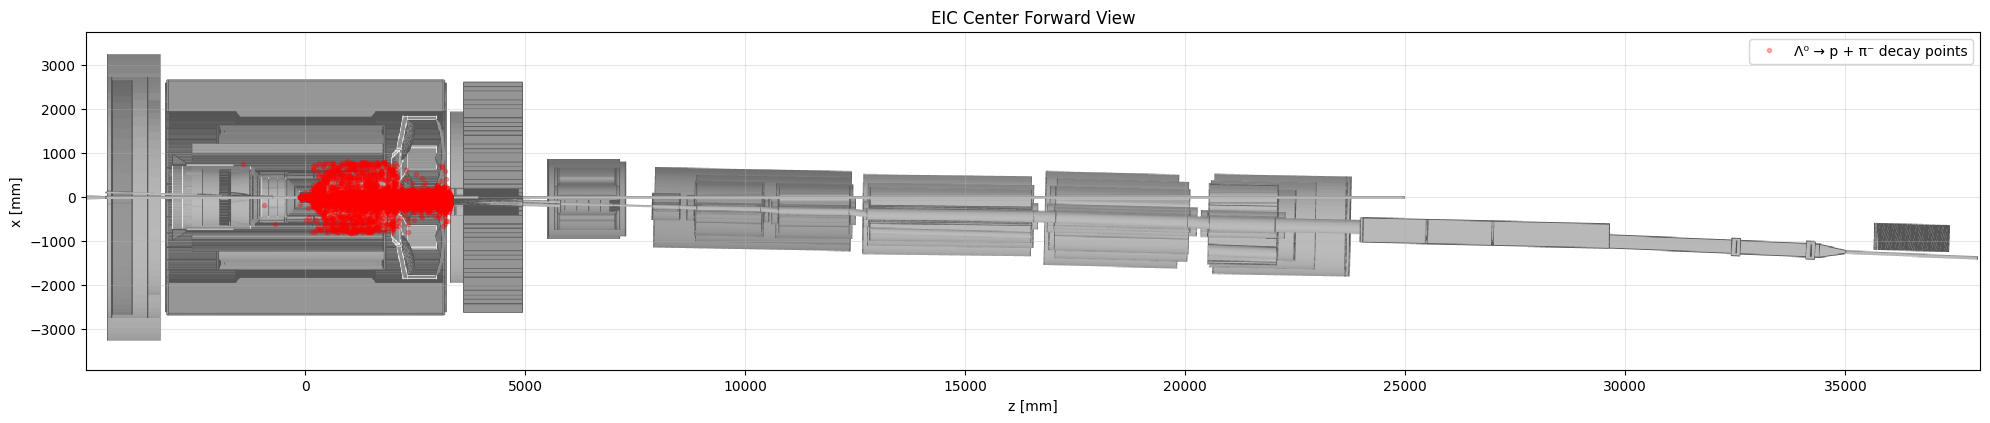

In [110]:
df_p_pi_minis

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_p_pi_minis['lam_epz']
y_axis = df_p_pi_minis['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

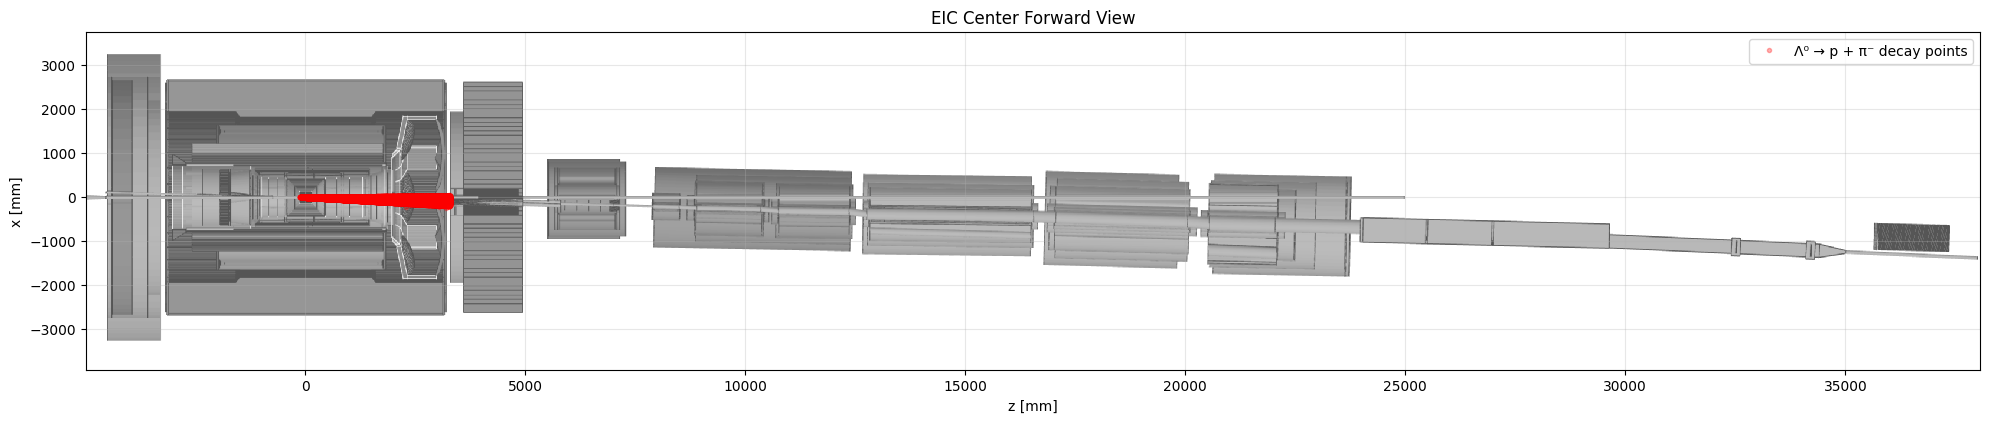

In [111]:
high_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == True]

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = high_energy_lambdas['lam_epz']
y_axis = high_energy_lambdas['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


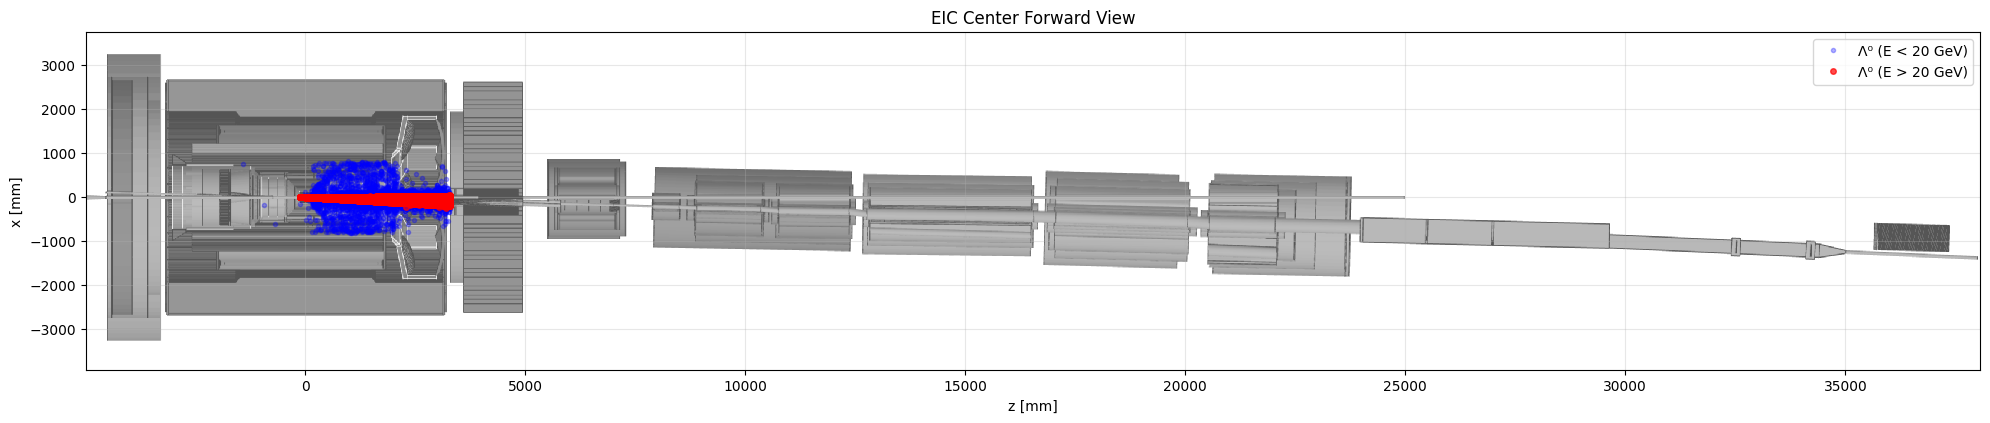

In [112]:
low_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == False]
high_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == True]

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")


ax.plot(low_energy_lambdas['lam_epz'], low_energy_lambdas['lam_epx'], 
        marker="o", linestyle="none", alpha=0.3, 
        color='blue', markersize=3, label='Λ⁰ (E < 20 GeV)')


ax.plot(high_energy_lambdas['lam_epz'], high_energy_lambdas['lam_epx'], 
        marker="o", linestyle="none", alpha=0.7,  
        color='red', markersize=4, label='Λ⁰ (E > 20 GeV)')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

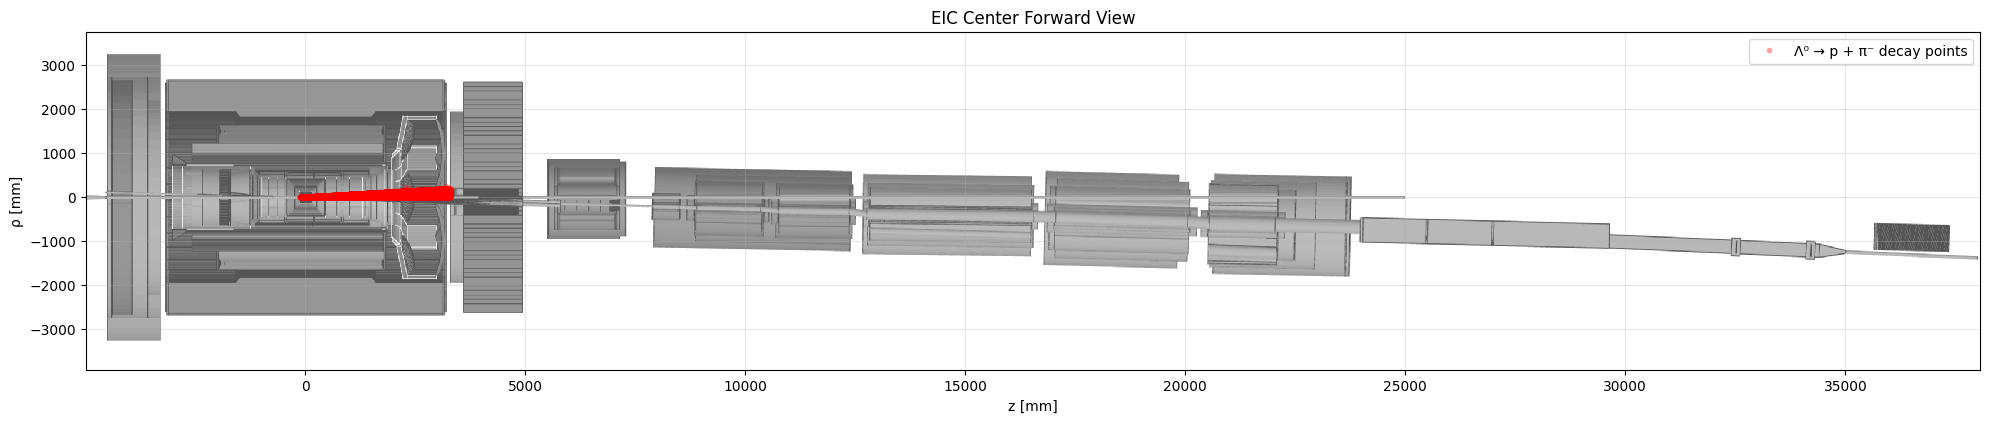

In [124]:

high_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == True]

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

rho = np.sqrt(high_energy_lambdas['lam_epx']**2 + high_energy_lambdas['lam_epy']**2)
y_axis = rho
x_axis = high_energy_lambdas['lam_epz']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_ylabel("ρ [mm]")
plt.tight_layout()
plt.show()



In [127]:
x = high_energy_lambdas['lam_epx']
y = high_energy_lambdas['lam_epy']
z = high_energy_lambdas['lam_epz']
r = np.sqrt(x**2+y**2+z**2)

In [138]:
df_neut_pizero_decays = df[
    df['prot_id'].isna() & 
    df['pimin_id'].isna() &
    df['neut_id'].notna()&    
    df['pizero_id'].notna()   
].copy()


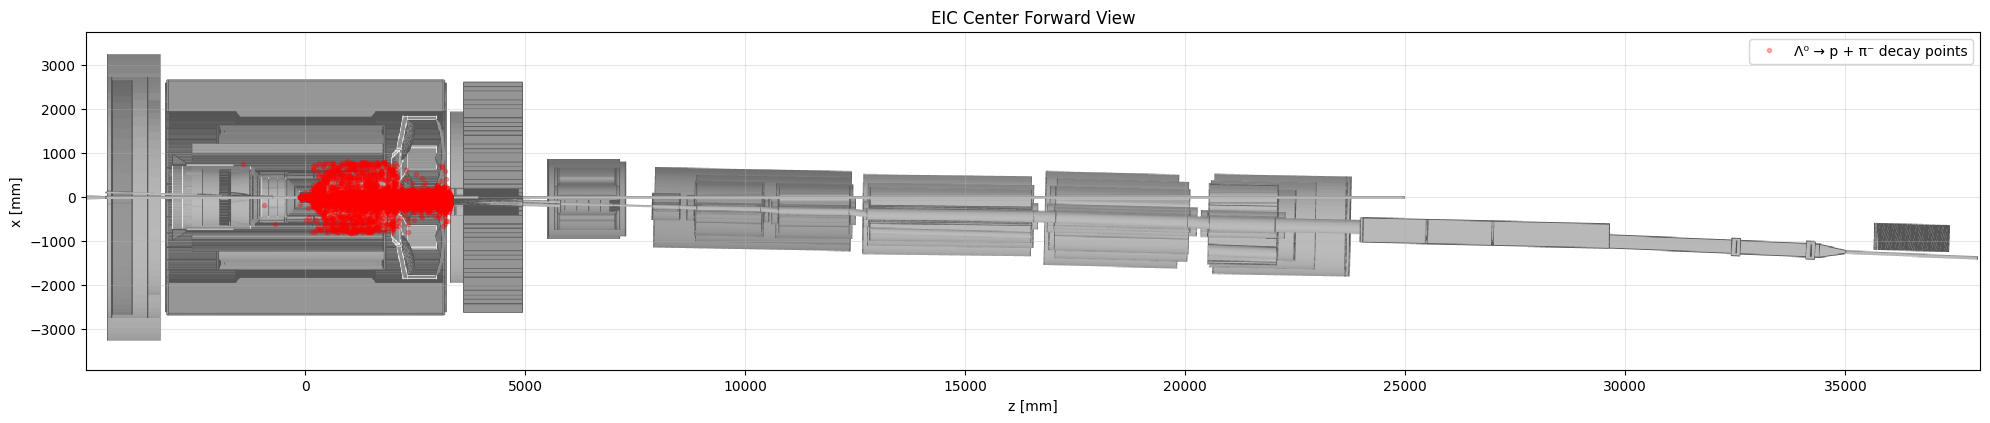

In [152]:

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_p_pi_minis['lam_epz']
y_axis = df_p_pi_minis['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [153]:
df_neut_pizero_decays = df[
    df['prot_id'].isna() & 
    df['pimin_id'].isna() &
    df['neut_id'].notna()&    
    df['pizero_id'].notna()   
].copy()


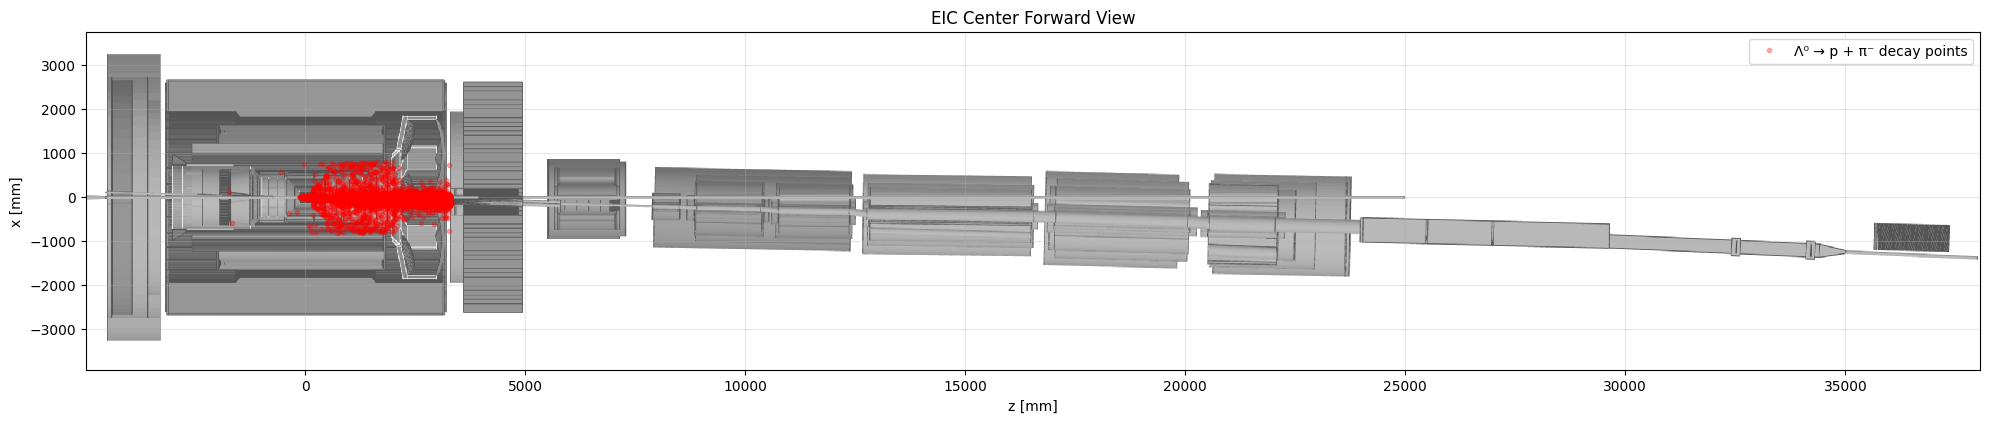

In [154]:
fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_neut_pizero_decays['lam_epz']
y_axis = df_neut_pizero_decays['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [155]:
df_neut = df[
    df['neut_id'].notna()&    
    df['pizero_id'].notna()   
].copy()

In [156]:
pizero_decays = df[
    df['prot_id'].isna() & 
    df['pimin_id'].isna() 
].copy()

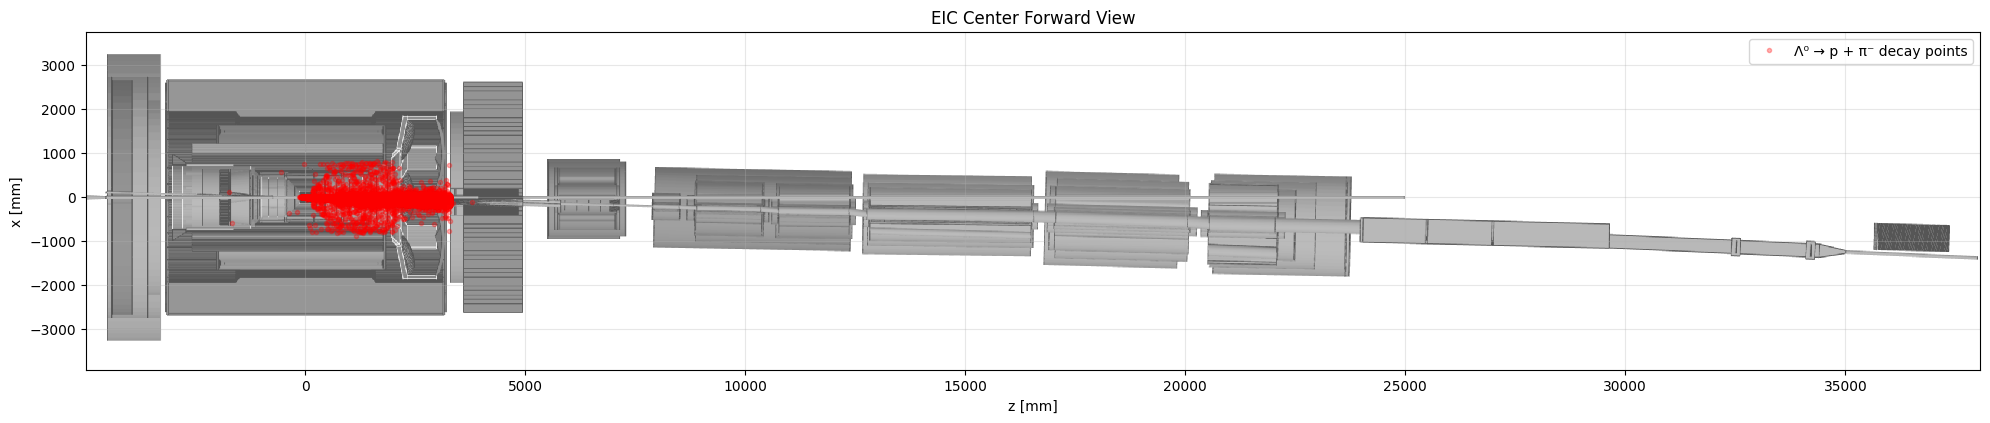

In [157]:
fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_neut['lam_epz']
y_axis = df_neut['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

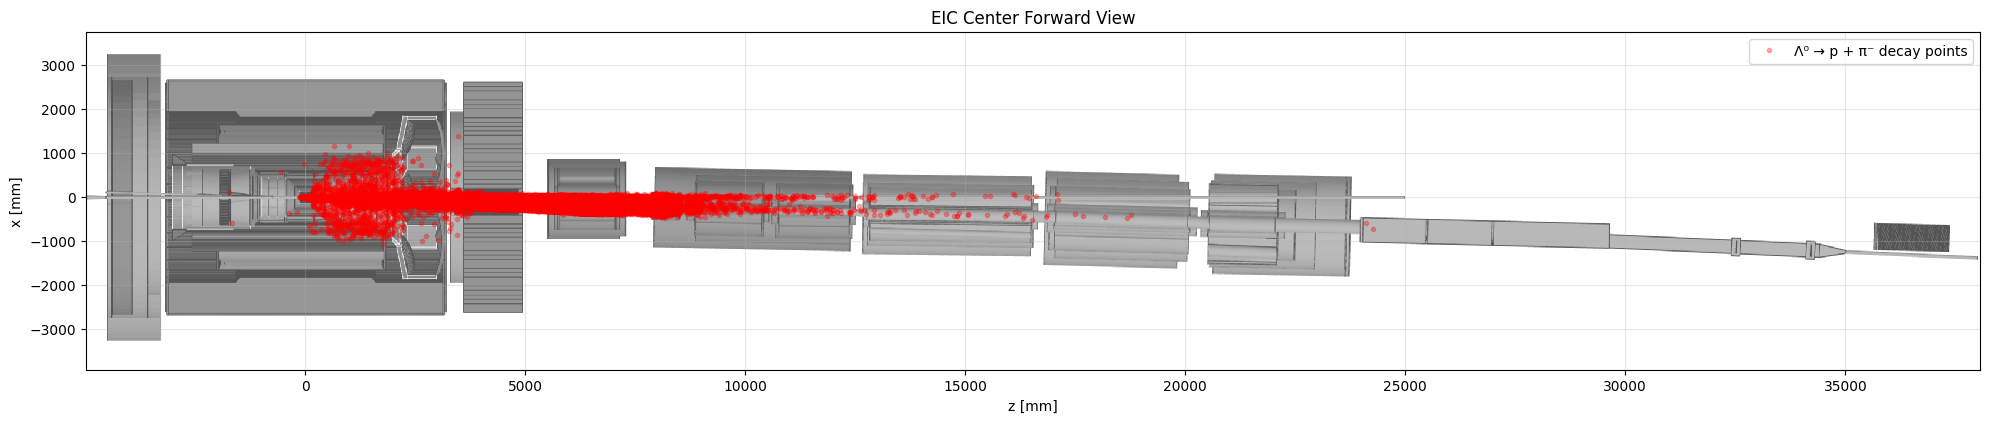

In [158]:
fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = pizero_decays['lam_epz']
y_axis = pizero_decays['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

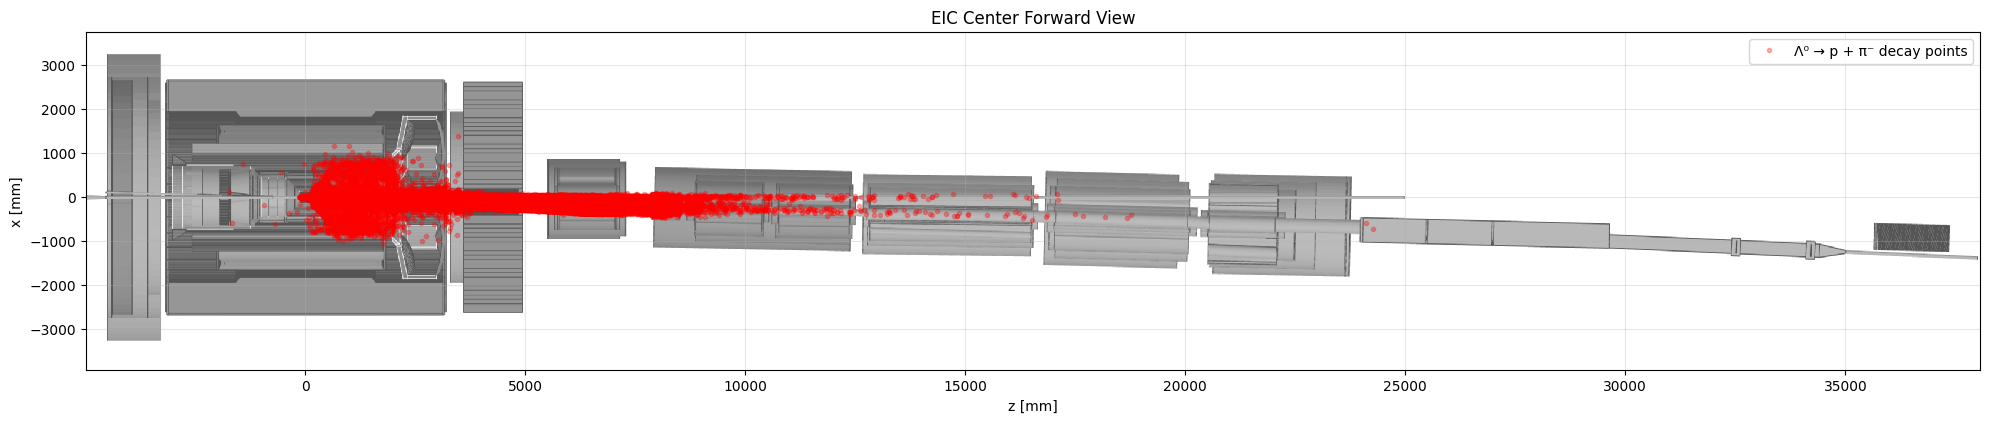

In [142]:
fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df['lam_epz']
y_axis = df['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

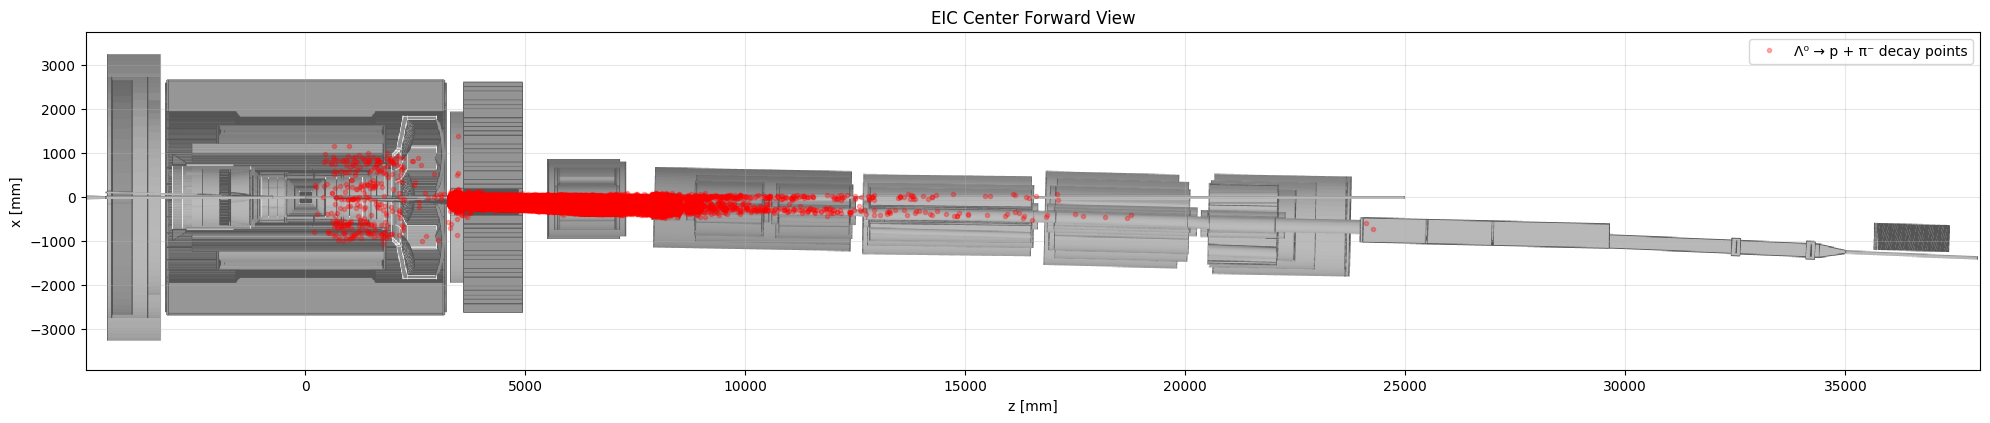

In [160]:
df_all = df[
    df['prot_id'].isna() & 
    df['pimin_id'].isna() & 
    df['neut_id'].isna() &     
    df['pizero_id'].isna()
].copy()


fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_all['lam_epz']
y_axis = df_all['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, label='Λ⁰ → p + π⁻ decay points')

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [161]:
df_all

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_py,gamtwo_pz,gamtwo_vx,gamtwo_vy,gamtwo_vz,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd
9,8,5,3122,0,1157627904,-0.818018,0.063256,13.308534,-80.747664,-66.968679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,17,4,3122,1,67108864,-0.708786,0.287691,21.392482,-0.102329,-0.003600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,19,4,3122,1,67108864,-1.375412,-0.193764,38.416661,-0.207011,0.011802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,21,4,3122,1,67108864,-0.893347,-0.291258,37.466020,-0.167363,-0.003283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,44,4,3122,1,83886080,-1.224206,0.801058,27.210498,0.039397,0.015456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563737,499951,4,3122,1,67108864,-0.884381,-0.583019,26.306741,-0.214993,0.004418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563747,499961,4,3122,1,67108864,-1.670106,-0.438270,40.398573,0.091534,0.015008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563750,499963,4,3122,1,67108864,0.097407,-0.141855,24.681384,-0.079878,0.010747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563752,499965,4,3122,1,83886080,-0.033550,0.506085,38.349849,0.032369,-0.008913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
